# Genetic algorithm tests for the Courier Problem

In [ ]:
import os
import sys

sys.path.append(os.path.abspath("../src"))

os.environ["PYTHONPATH"] = os.path.abspath("../src")

import ray

if ray.is_initialized():
    ray.shutdown()

ray.init(
    runtime_env={"env_vars": {"PYTHONPATH": os.environ["PYTHONPATH"]}},
    include_dashboard=True,
    dashboard_port=8265,
)


2025-06-13 02:19:41,540	INFO worker.py:1879 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.12.3
Ray version:,2.46.0
Dashboard:,http://127.0.0.1:8265


(raylet) [2025-06-13 02:35:41,477 E 186407 186407] (raylet) node_manager.cc:3287: 2 Workers (tasks / actors) killed due to memory pressure (OOM), 0 Workers crashed due to other reasons at node (ID: b6012f7c7a967a83e2e8fbe2b2741a2dcf856def74ba86370bd5b8a5, IP: 172.24.109.133) over the last time period. To see more information about the Workers killed on this node, use `ray logs raylet.out -ip 172.24.109.133`
(raylet) 
(raylet) Refer to the documentation on how to address the out of memory issue: https://docs.ray.io/en/latest/ray-core/scheduling/ray-oom-prevention.html. Consider provisioning more memory on this node or reducing task parallelism by requesting more CPUs per task. To adjust the kill threshold, set the environment variable `RAY_memory_usage_threshold` when starting Ray. To disable worker killing, set the environment variable `RAY_memory_monitor_refresh_ms` to zero.
(raylet) 
(raylet) [2025-06-13 02:38:41,479 E 186407 186407] (raylet) node_manager.cc:3287: 4 Workers (tasks / 

In [2]:
from itertools import chain, combinations


def get_all_subsets(lst):
    return list(chain.from_iterable(combinations(lst, r) for r in range(len(lst) + 1)))


In [3]:
from ga.mutations import (
    CouriersMutation,
    Mutation,
    PackagesMutation,
    RouteMutation,
    UnusedVehiclesMutation,
    UsedVehiclesMutation,
)

all_mutations: list[Mutation] = [
    UsedVehiclesMutation,
    UnusedVehiclesMutation,
    CouriersMutation,
    PackagesMutation,
    RouteMutation,
]

mutation_suite = get_all_subsets(all_mutations)
print(mutation_suite)

[(), (<class 'ga.mutations.vehicles.UsedVehiclesMutation'>,), (<class 'ga.mutations.vehicles.UnusedVehiclesMutation'>,), (<class 'ga.mutations.couriers.CouriersMutation'>,), (<class 'ga.mutations.packages.PackagesMutation'>,), (<class 'ga.mutations.route.RouteMutation'>,), (<class 'ga.mutations.vehicles.UsedVehiclesMutation'>, <class 'ga.mutations.vehicles.UnusedVehiclesMutation'>), (<class 'ga.mutations.vehicles.UsedVehiclesMutation'>, <class 'ga.mutations.couriers.CouriersMutation'>), (<class 'ga.mutations.vehicles.UsedVehiclesMutation'>, <class 'ga.mutations.packages.PackagesMutation'>), (<class 'ga.mutations.vehicles.UsedVehiclesMutation'>, <class 'ga.mutations.route.RouteMutation'>), (<class 'ga.mutations.vehicles.UnusedVehiclesMutation'>, <class 'ga.mutations.couriers.CouriersMutation'>), (<class 'ga.mutations.vehicles.UnusedVehiclesMutation'>, <class 'ga.mutations.packages.PackagesMutation'>), (<class 'ga.mutations.vehicles.UnusedVehiclesMutation'>, <class 'ga.mutations.route.Ro

In [4]:
import glob
import os

from model import Problem
from utils import load_from_json

data_dir = "data"
json_files = glob.glob(os.path.join(data_dir, "*.json"))

data: list[tuple[str, Problem]] = []
for json_file in json_files:
    testcase_name = os.path.basename(json_file).replace(".json", "")
    problem = load_from_json(json_file)
    data.append((testcase_name, problem))

data.sort(key=lambda x: x[0])

In [5]:
GA_RUN_PATIENCE = 25
GA_INITIAL_POPULATION_SIZE = 50
GA_MAX_RUN_ITERATIONS = 300
GA_RUN_REPEAT = 10

CONFIG = {
    "GA_RUN_PATIENCE": GA_RUN_PATIENCE,
    "GA_INITIAL_POPULATION_SIZE": GA_INITIAL_POPULATION_SIZE,
    "GA_MAX_RUN_ITERATIONS": GA_MAX_RUN_ITERATIONS,
    "GA_RUN_REPEAT": GA_RUN_REPEAT,
}

In [ ]:
import time

import numpy as np

from ga import GA


@ray.remote
def run_single_ga_repeat(problem, mutations, population, config):
    GA_RUN_PATIENCE = config["GA_RUN_PATIENCE"]
    GA_MAX_RUN_ITERATIONS = config["GA_MAX_RUN_ITERATIONS"]

    best_solution_cost = np.inf
    patience = GA_RUN_PATIENCE
    num_iterations = 0

    for mutation in all_mutations:
        if mutation not in mutations:
            mutation.proba = 0
        else:
            mutation.proba = 0.5

    ga = GA(problem=problem, initial_population=population, C=1.2, alpha=0.9)

    start_time = time.perf_counter()

    for state in ga.run(max_iter=GA_MAX_RUN_ITERATIONS):
        current_cost = ga.get_cost(state.solution)

        if current_cost < best_solution_cost:
            best_solution_cost = current_cost
            patience = GA_RUN_PATIENCE
        else:
            patience -= 1

        if patience <= 0:
            break
        num_iterations += 1

    elapsed_time = time.perf_counter() - start_time

    return {
        "cost": best_solution_cost,
        "iterations": num_iterations,
        "time": elapsed_time,
        "cost_func_evals": ga._cost_function_runs,
    }


@ray.remote
def run_suite_for_testcase_remote(
    testcase_name, problem, mutations, population, config
):
    GA_RUN_REPEAT = config["GA_RUN_REPEAT"]

    futures = [
        run_single_ga_repeat.remote(problem, mutations, population, config)
        for _ in range(GA_RUN_REPEAT)
    ]

    results = ray.get(futures)

    best_costs = [r["cost"] for r in results]
    iterations_list = [r["iterations"] for r in results]
    times = [r["time"] for r in results]
    cost_func_evals = [r["cost_func_evals"] for r in results]

    stats = {
        "testcase": testcase_name,
        "mutation_suite": [m.__name__ for m in mutations],
        "cost_mean": np.mean(best_costs),
        "cost_std": np.std(best_costs),
        "cost_max": max(best_costs),
        "cost_min": min(best_costs),
        "cost_median": np.median(best_costs),
        "iterations_mean": np.mean(iterations_list),
        "iterations_std": np.std(iterations_list),
        "iterations_min": min(iterations_list),
        "iterations_max": max(iterations_list),
        "iterations_median": np.median(iterations_list),
        "time_mean": np.mean(times),
        "time_std": np.std(times),
        "time_min": min(times),
        "time_max": max(times),
        "time_median": np.median(times),
        "cost_func_evals_min": min(cost_func_evals),
        "cost_func_evals_max": max(cost_func_evals),
        "cost_func_evals_mean": np.mean(cost_func_evals),
        "cost_func_evals_std": np.std(cost_func_evals),
        "cost_func_evals_median": np.median(cost_func_evals),
    }

    stats = {k: round(v, 2) if isinstance(v, float) else v for k, v in stats.items()}

    return stats

In [7]:
import os

import pandas as pd
from tqdm.notebook import tqdm

from generator import Generator

results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

for testcase_name, problem in tqdm(data, desc="Testcases"):
    generator = Generator(problem=problem)
    population = generator.generate_many_feasible(
        num_to_find=GA_INITIAL_POPULATION_SIZE, max_attempts=1000, verbose=False
    )

    futures = []
    metadata = []
    for mutations in mutation_suite:
        future = run_suite_for_testcase_remote.remote(
            testcase_name, problem, mutations, population, config=CONFIG
        )
        futures.append(future)
        metadata.append([m.__name__ for m in mutations])

    testcase_results = []
    with tqdm(total=len(futures), desc=f"Mutations for {testcase_name}") as pbar:
        for i, future in enumerate(futures):
            try:
                res = ray.get(future)
                testcase_results.append(res)
            except Exception as e:
                print(
                    f"ERROR in testcase {testcase_name}, mutations {metadata[i]}: {e}"
                )
            pbar.update(1)

    if testcase_results:
        df = pd.DataFrame(testcase_results)
        filename = os.path.join(results_dir, f"{testcase_name}_results.csv")
        df.to_csv(filename, index=False)


Testcases:   0%|          | 0/3 [00:00<?, ?it/s]

Mutations for big:   0%|          | 0/32 [00:00<?, ?it/s]

Mutations for correctness:   0%|          | 0/32 [00:00<?, ?it/s]

Mutations for medium:   0%|          | 0/32 [00:00<?, ?it/s]

In [12]:
# Load all result CSV files
all_results = []
for file in glob.glob(os.path.join(results_dir, "*_results.csv")):
    df = pd.read_csv(file)
    df["testcase"] = os.path.basename(file).replace("_results.csv", "")
    all_results.append(df)

all_results_df = pd.concat(all_results, ignore_index=True)

for testcase in all_results_df["testcase"].unique():
    group = all_results_df[all_results_df["testcase"] == testcase]
    min_cost = group["cost_min"].min()
    best_rows = group[group["cost_min"] == min_cost]
    print(f"Testcase: {testcase}")
    for muts in best_rows["mutation_suite"]:
        print(muts)

Testcase: correctness
['PackagesMutation']
['UsedVehiclesMutation', 'PackagesMutation']
['UnusedVehiclesMutation', 'PackagesMutation']
['CouriersMutation', 'PackagesMutation']
['PackagesMutation', 'RouteMutation']
['UsedVehiclesMutation', 'UnusedVehiclesMutation', 'PackagesMutation']
['UsedVehiclesMutation', 'CouriersMutation', 'PackagesMutation']
['UsedVehiclesMutation', 'PackagesMutation', 'RouteMutation']
['UnusedVehiclesMutation', 'CouriersMutation', 'PackagesMutation']
['UnusedVehiclesMutation', 'PackagesMutation', 'RouteMutation']
['CouriersMutation', 'PackagesMutation', 'RouteMutation']
['UsedVehiclesMutation', 'UnusedVehiclesMutation', 'CouriersMutation', 'PackagesMutation']
['UsedVehiclesMutation', 'UnusedVehiclesMutation', 'PackagesMutation', 'RouteMutation']
['UsedVehiclesMutation', 'CouriersMutation', 'PackagesMutation', 'RouteMutation']
['UnusedVehiclesMutation', 'CouriersMutation', 'PackagesMutation', 'RouteMutation']
['UsedVehiclesMutation', 'UnusedVehiclesMutation', 'Co

In [20]:
best_mutations = [
    PackagesMutation,
    RouteMutation,
    CouriersMutation,
    UsedVehiclesMutation,
]

In [30]:
ITERATIONS_SUITE = np.linspace(10, 400, num=100)

In [39]:
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

for iterations in tqdm(ITERATIONS_SUITE, desc="Iterations % complete"):
    futures = []
    for testcase_name, problem in data:
        generator = Generator(problem=problem)
        population = generator.generate_many_feasible(
            num_to_find=GA_INITIAL_POPULATION_SIZE, max_attempts=1000, verbose=False
        )
        config = CONFIG.copy()
        config["GA_MAX_RUN_ITERATIONS"] = int(iterations)
        config["GA_RUN_PATIENCE"] = 1e6
        config["GA_RUN_REPEAT"] = 5
        future = run_suite_for_testcase_remote.remote(
            testcase_name, problem, best_mutations, population, config=config
        )
        futures.append(future)

    # Collect only mean cost stat for each testcase
    results = ray.get(futures)
    mean_costs = []
    for res in results:
        mean_costs.append(
            {
                "testcase": res["testcase"],
                "iterations": iterations,
                "cost_mean": res["cost_mean"],
            }
        )
    # Store mean_costs for plotting later
    if "all_mean_costs" not in globals():
        all_mean_costs = []
    all_mean_costs.extend(mean_costs)

Iterations % complete:   0%|          | 0/100 [00:00<?, ?it/s]

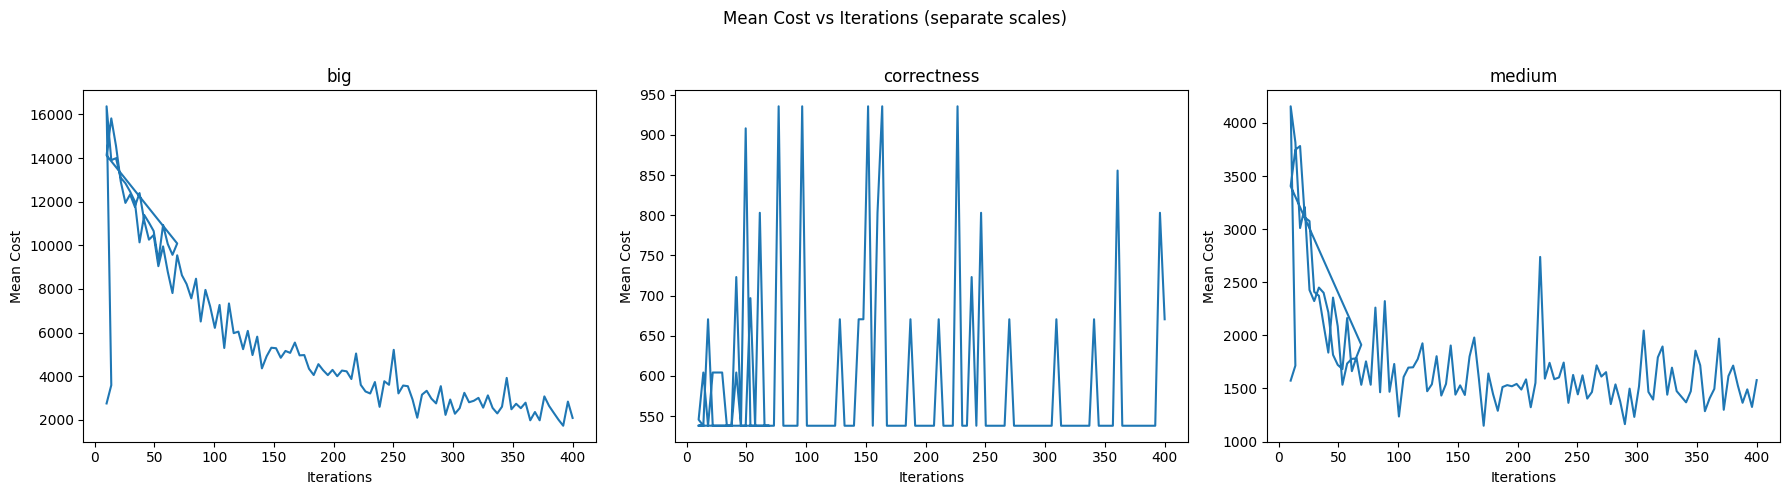

In [42]:
# After all loops are done, plot iterations over cost
plot_df = pd.DataFrame(all_mean_costs)
# Split into 3 plots with separate y-scales
testcases = plot_df["testcase"].unique()
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)
for ax, testcase in zip(axes, testcases):
    subset = plot_df[plot_df["testcase"] == testcase]
    ax.plot(subset["iterations"], subset["cost_mean"], label=testcase)
    ax.set_xlabel("Iterations")
    ax.set_title(testcase)
    ax.set_ylabel("Mean Cost")
plt.suptitle("Mean Cost vs Iterations (separate scales)")
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
INITIAL_POPLUATION_SUITE = np.linspace(10, 200, num=100)